In [1]:
import torch.nn as nn
import torch
import pytorch_lightning as pl
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split

from src.utils import set_seed
from src.dataloaders import get_loaders, HARDataset
from src.network import HARNet
from src.pl_module import HARModule

/opt/anaconda3/envs/srr_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EDA

1) Быстрый взгляд на файлы с данными показал, что они сильно несбалансированы. В среднем, в файле около 6% объектов позитивного класса. Худшее значение 0 (в записи полностью отсутствует этап "прием пищи"), лучшее 15%. Это стоит иметь ввиду в дальнейшем решении.


2) Пропуски, битые значение и т.д., замечены не были, по крайней мере лоадер и модель не ругались :)


3) Вопиющих выбросов тоже замечено не было. Есть один подозрительный файл ('0001__R__2DBF__2019-10-08__104851__Accel-GYRO.npz'), в котором статистики по показаниям гироскопа сильно отличаются от всей остальной выборки. Его было решено исключить. 


4) Решаем задачу как бинарную классификацию, предварительно нарезав исходные данные "окнами".

# Preprocessing

Мне привычнее работать с сетками и торчевским даталоадером, поэтому многие решения продиктованы именно этим. 

Для начала разбиваем имеющиеся данные на выборки по файлам. Это не совсем правильно с точки зрения идеальной валидации, но просто и надежно (только пришлось проверить, чтобы в валидационныую и тестовую выбору не попали исключительно записи без позитивного класса). Так же не делал стратификацию по данным, которые можно измвлечь из названия файлов, думаю рандом сплита хватит. Для начала - сойдет.

In [2]:
set_seed()

DATA_DIR = './data_compressed/'
bad_file_name = '0001__R__2DBF__2019-10-08__104851__Accel-GYRO.npz'
record_files = [x for x in os.listdir(DATA_DIR) if x!=bad_file_name]

rec_train, rec_hold = train_test_split(record_files, test_size=0.2, random_state=10)
rec_val, rec_test = train_test_split(rec_hold, test_size=0.1, random_state=10)

# Что еще не было сделано:

1) Нормализация, удаление выбросов, сглаживание, применение фильтров по частоте, более детальный анализ сырых данных. Так же неплохо было бы убедиться, что указанная частота снятия сэмплов соответствует действительности. 


2) При нарезке данных "окнами" была выбрана самая простая стратегия - без пересечений. Если делать окна со сдвигом, качество финального предсказания будет лучше.


2) Дополнительный feature engineering. Например можно было посчитать разные производные показатели внутри окна, распарсить метаданные (время приема пищи) и тд. 


3) Постпроцессинг. Есть понимание, что после того, как сделали предсказание по окнам, нужно выделять непрерывные участки "приема пищи", это сильно повысит качество.


4) Перебор всех возможных гиперпараметров и архитектуры сетки.


5) Вынести отдельно конфиг, трекать эксперименты в логгер, сохранение/загрузка лучших чекпойнтов модели, применение более продвинутых оптимайзеров/шедулеров и вообще всякая инженерная составляющая. Это показалось излишним, при условии, что особо модель не нужно было фиттить (прогоняю только две эпохи).

In [3]:
batch_size = 256 
window_size = 60 # I think for a start, 6 seconds is close to the optimal value

# it takes time
train_loader, val_loader, test_loader = get_loaders(DATA_DIR, rec_train, rec_val, rec_test, 
                                                    batch_size, window_size)

In [4]:
model = HARNet(window_size)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
pl_module = HARModule(model, loss_fn, optimizer)

# Training 

In [5]:
trainer = pl.Trainer(max_epochs=2, # I am limited in computing resources :(
                     accelerator='cpu')
trainer.fit(model=pl_module, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params
----------------------------------------------
0 | model   | HARNet            | 399 K 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
399 K     Trainable params
0         Non-trainable params
399 K     Total params
1.598     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/anaconda3/envs/srr_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|███████████████| 2/2 [00:00<00:00,  2.49it/s]Val epoch Loss: 0.0027803427
                                                                                

/opt/anaconda3/envs/srr_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  74%|████████   | 153/208 [03:35<01:17,  1.41s/it, loss=0.352, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████| 208/208 [04:09<00:00,  1.20s/it, loss=0.352, v_num=1]
                                                                                Train epoch Loss: 0.0015685378
Epoch 1:  74%|████████   | 153/208 [03:32<01:16,  1.39s/it, loss=0.336, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 1:  89%|█████████▊ | 186/208 [03:53<00:27,  1.26s/it, loss=0.336, v_num=1]


Epoch 1: 100%|███████████| 208/208 [04:08<00:00,  1.20s/it, loss=0.336, v_num=1]
                                                                                Train epoch Loss: 0.0013515735
Epoch 1: 100%|███████████| 208/208 [04:08<00:00,  1.20s/it, loss=0.336, v_num=1]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|███████████| 208/208 [04:08<00:00,  1.20s/it, loss=0.336, v_num=1]


# Inference

In [6]:
output = trainer.predict(model=pl_module, dataloaders=test_loader)

/opt/anaconda3/envs/srr_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|████████████████████| 9/9 [00:03<00:00,  2.67it/s]


In [33]:
threshold = 0.9

sig = nn.Sigmoid()

y_prob = torch.cat([sig(x[0]) for x in output])
y_gt = torch.cat([x[1] for x in output])
y_pred = torch.where(y_prob > threshold, 1, 0)

# Window-wise metrcis

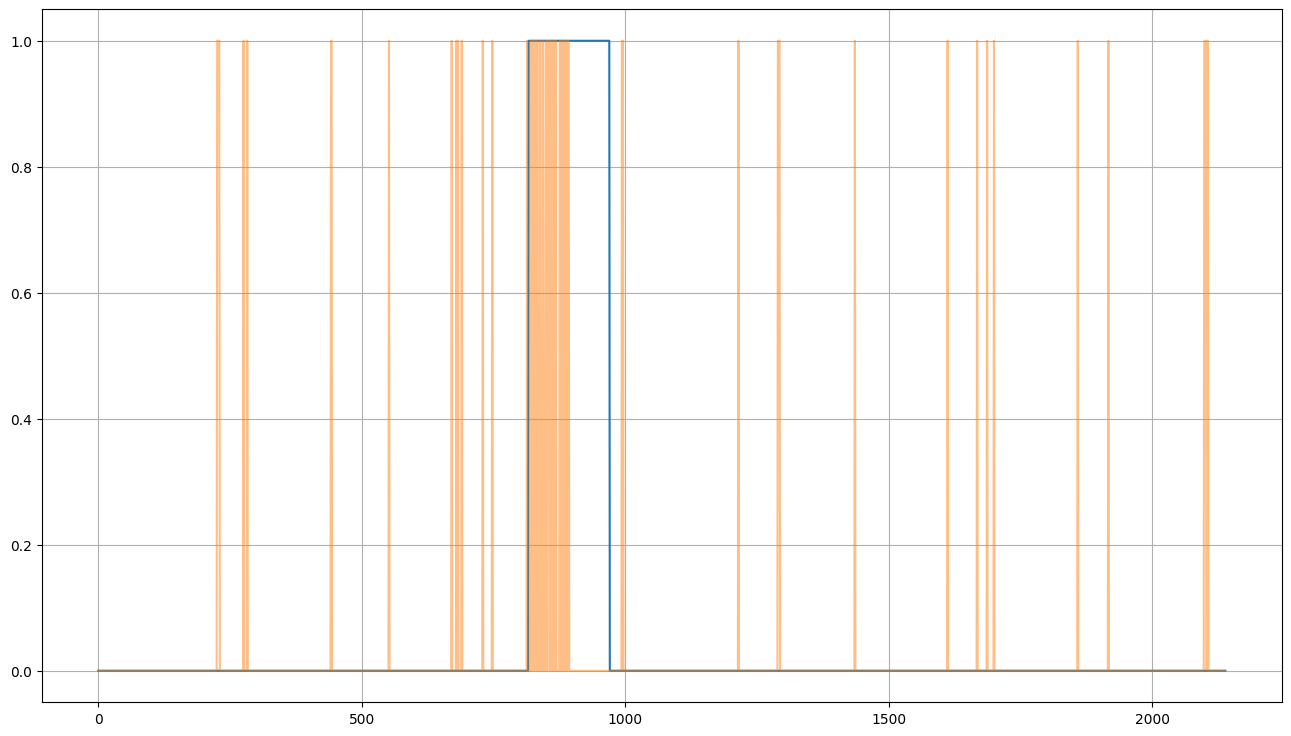

In [34]:
plt.figure(figsize=(16,9))
plt.plot(y_gt)
plt.plot(y_pred, alpha=0.5)
plt.grid(True);

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      1986
         1.0       0.49      0.23      0.31       154

    accuracy                           0.93      2140
   macro avg       0.71      0.60      0.64      2140
weighted avg       0.91      0.93      0.91      2140

ROC AUC: 0.8307535867958828


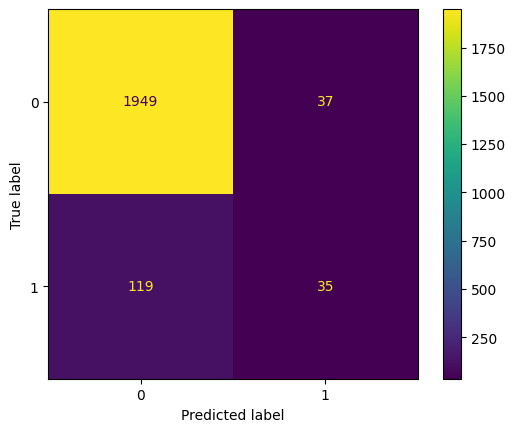

In [35]:
print(classification_report(y_gt, y_pred))
print('ROC AUC:', roc_auc_score(y_gt, y_prob))

disp = ConfusionMatrixDisplay(confusion_matrix(y_gt, y_pred))
disp.plot()
plt.show();

# Point-wise metrics

In [36]:
test_dataset = HARDataset(data_dir=DATA_DIR, rec_names=rec_test, window_size=window_size)

test_df = test_dataset.get_origin_df()
point_y_gt = test_df['target']
point_y_pred = y_pred.repeat_interleave(60)
point_y_prob = y_prob.repeat_interleave(60)

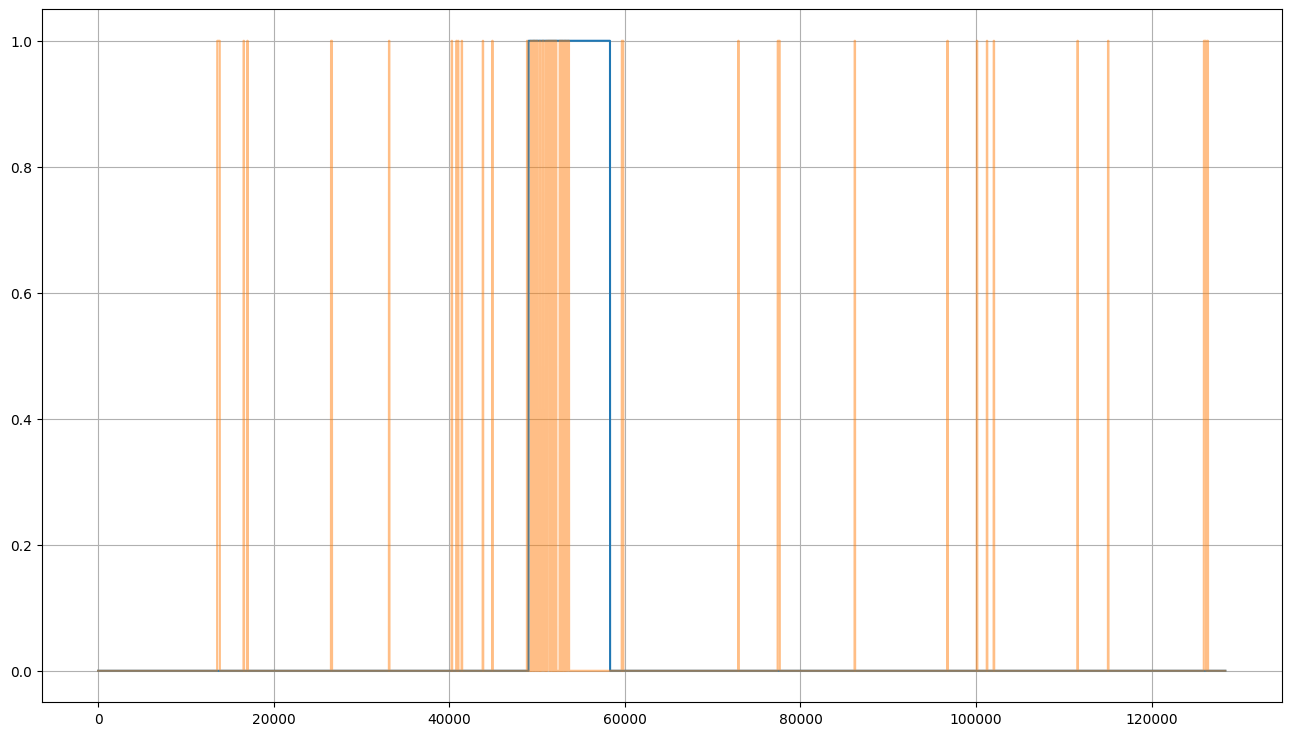

In [37]:
plt.figure(figsize=(16,9))
plt.plot(point_y_gt)
plt.plot(point_y_pred, alpha=0.5)
plt.grid(True);

              precision    recall  f1-score   support

           0       0.94      0.98      0.96    119118
           1       0.49      0.23      0.31      9282

    accuracy                           0.93    128400
   macro avg       0.71      0.60      0.64    128400
weighted avg       0.91      0.93      0.91    128400

ROC AUC: 0.8294985760074751


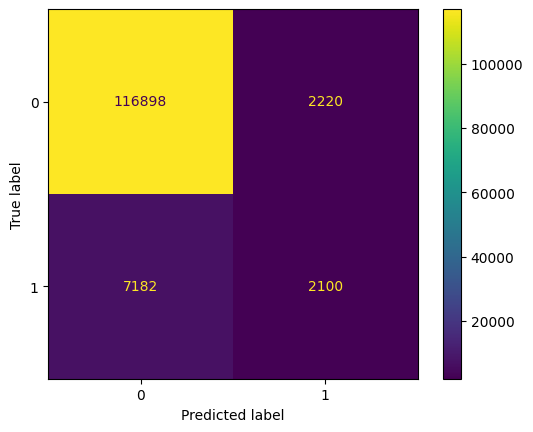

In [38]:
print(classification_report(point_y_gt, point_y_pred))
print('ROC AUC:', roc_auc_score(point_y_gt, point_y_prob))

disp = ConfusionMatrixDisplay(confusion_matrix(point_y_gt, point_y_pred))
disp.plot()
plt.show();

# Conclusion 

Как можно заметить, решение вроде рабочее (ROC AUC выше 0.5), можно сказать, что proof-of-concept получен)

Из слабых мест - недостаточное время на обучение (две эпохи, сетка далека от сходимости), плюс все что было перечислено ранее в блоке "Что еще не было сделано".

Так же можно отметить, что агрессивный баланс классов сыграл злую шутку, пристуствует много ошибок второго рода, это тоже неплохо было бы пофиксить, а не просто выкручивать порог на очень высокие значения. 

В целом - было интересно сделать задание :)